# Capstone Project - The Battle of Mumbai Neighborhoods For Next Chinese Restaurant

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project I will try to provide solution a hypothetical business requirement.

I have been approached by the owner of a authentic Chinese restaurant chain to find the next best neighbourhood in Mumbai city for opening a new Chinese restaurant. 

Mumbai being the melting pot of India is full of restaurants of all sorts of cuisine, with most them multi-cuisine. 

The objective of the project is to find the best possible location for a Chinese restaurant. The report will be useful to those who would like to open a Chinese restaurant in Mumbai, India.

The criteria for selecting a neighbourhood would be:

* Location with high average visit stats of restaurants
* Total number of restaurants in the neighborhood 
* Areas with no or one Chinese restaurant
* Population base

## Data <a name="data"></a>

In this section we will collect, clean and format data. But first lets import required libraries, define important functions and foursquare credentials

### Import as many library as possible

In [2]:
#### import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium.features import DivIcon

# Web scrapping
from bs4 import BeautifulSoup
import urllib.request
import csv

import os

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score

from math import sin, cos, sqrt, atan2, radians

import numpy as np

print('Libraries imported.')

Libraries imported.


### Fousquare Credenials

In [ ]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Important Functions

In [4]:
#Function to convert lattitude/longitude from degree to float 
def conversion(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(u'°',' ').replace('′',' ').replace('″',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (float(new[0])+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]
        
#Function to get lat long from link
def getLatLongFromGoogle(neighbour):
    up =  'https://maps.googleapis.com/maps/api/geocode/json?address={},Mumbai&key=<google api goes here>'.format(neighbour) #'https://en.wikipedia.org'+lnk #/wiki/List_of_neighbourhoods_in_Mumbai'
    # query the website and return the html to the variable 'page'
    pg = requests.get(up).json() #urllib.request.urlopen(up)
    #print(pg['results'][0]['geometry']['location'])
    #print(neighbour, up)
    try:
        #ltln = sn.getText().replace(u'°','').replace('N','').replace('E','').split()
        #results['response']['groups'][0]['items']
        #print(neighbour, pg['results'][0]['geometry']['location']['lat'], pgpg['results'][0]['location']['lng'])
        lat = float(pg['results'][0]['geometry']['location']['lat'])
        lng = float(pg['results'][0]['geometry']['location']['lng'])
    except:
        print(neighbour, 0,0)
        lat = 0
        lng = 0
    
    return lat, lng
        

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# function to get statistics of venues like number of tips, number of users, number of check-in, number of visit counts
def getStats(ids):
    nhdtfile =  open('exception_log.txt','a')
    vcnts=[]
    i = 0;
    for id in ids:
        i += 1;
        if (i%100 == 0):
            print(i,'..........')
            
        #if (i == 300):
           # break
        u = 'https://api.foursquare.com/v2/venues/{}?callback=<jquery and auth token go here>&v=20190414&_=1555252038389'.format(id)
        r = requests.get(u)
        rtext = r.text
        rtext = rtext.replace('jQuery17207694623999914458_1555252017122(','')[:-2]#.replace('"algoVersion":3}}}});', '"algoVersion":3}}}}')

        tipCount = 0
        usersCount = 0
        checkinsCount = 0
        visitsCount = 0

        try :
            rj = json.loads(rtext)
            tipCount = int(rj['response']['venue']['stats']['tipCount'])
            usersCount = int(rj['response']['venue']['stats']['usersCount'])
            checkinsCount = int(rj['response']['venue']['stats']['checkinsCount'])
            visitsCount = int(rj['response']['venue']['stats']['visitsCount'])

            vcnts.append([(id,tipCount,usersCount,checkinsCount,visitsCount)])
            
        except Exception as e :
            print('getStats',id,': Exception: ',str(e),'\n', rtext, file = nhdtfile)
    
    nhdtfile.close()
    
    print(len(vcnts))
    print(vcnts[1:10])
    venstats = pd.DataFrame([item for vcnts in vcnts for item in vcnts])
    print(venstats.head())
    venstats.columns = ['Venue ID',
                  'Venue Tips Count', 
                  'Venue User Counts', 
                  'Venue Checkin Counts', 
                  'Venue Visits Counts']
    
    return venstats
    
# fuction to calculate distance between to locations based on their latitude/longitude
def getDistance(dlat1,dlon1,dlat2,dlon2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(dlat1)
    lon1 = radians(dlon1)
    lat2 = radians(dlat2)
    lon2 = radians(dlon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000

    return distance

# Function to get restaurants near a location based on distance
def getNearbyRestaurants(names, latitudes, longitudes, radius=500, category='4d4b7105d754a06374d81259'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        #url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            #CLIENT_ID, 
            #CLIENT_SECRET, 
            #VERSION, 
            #lat, 
            #lng, 
            #radius, 
            #LIMIT)
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, category, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(name, len(results))
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            getDistance(float(lat), float(lng), float(v['venue']['location']['lat']),float(v['venue']['location']['lng']))) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Distance']
    
    return(nearby_venues)

# Function to get population base of a neighborhood
def getApproxPopulation(lnk) :
    
    ppl = 0.0
    
    up =  'https://en.wikipedia.org'+lnk
    #print(up)
    # query the website and return the html to the variable 'page'
    pg = urllib.request.urlopen(up)
    sp = BeautifulSoup(pg, 'html.parser')
    cps = sp.find_all('caption')
    mhtrnou2014 = 56.0 # Maharashtra turnout percentage
    #print(len(cps))
    #print (len(cps), cps[len(cps)-1].getText())
    for cp in cps :
        #print(cp.getText())
        if '2014' in cp.getText(): #'Maharashtra Legislative Assembly election, 2014' in cp:
            #print(cp.getText())
            trs = cp.parent.find_all('tr')
            print (len(trs))
            for tr in  trs:
                if 'Turnout' in tr.getText():
                    tds = tr.find_all('td')
                    # Get the turnout - actual number of people who voted
                    trnot = float(tds[0].getText().replace('\r','').replace('\n','').replace(',','')) 
                    # Get the turnout percentage if available else use Maharashtra state turnout percentage
                    tp = tds[1].getText().replace('\r','').replace('\n','').replace(',','')
                    trnotp = mhtrnou2014 if tp == '' or tp == None else float(tp)
                    # Calculate population (Above 18 years age) from  trunout and turnout percentage
                    ppl = int((trnot*100.0)/trnotp)
                    #print (cp.getText(),'trnot =',trnot,'tp =', trnotp, 'ppl =',ppl,'ntp = {:0.2f}'.format((trnot*100.0)/float(ppl)))
                    
    return ppl

# Function to get nearby venues (all venues)
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print(name, len(results))
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            getDistance(float(lat), float(lng), float(v['venue']['location']['lat']),float(v['venue']['location']['lng']))) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Distance']
    print(name,nearby_venues.shape)
    
    return(nearby_venues)

def rownames_to_column(df,colname) :
    df.index.name = colname
    df.reset_index(inplace=True)
    

Following are the rules for selection of neighbourhood:
* Number restaurants in the neighbourhood
* Number of Chinese restaurants in the neighbourhood and their distance from the centre of neighbourhood
    
Following data sources will be used to collect data:
* **Wikipedia** for Mumbai neighbourhoods and their co-ordinates.
* **Foursquare** for restaurant data
* Co-ordinates of Mumbai center will be obtained from **www.latlong.net** using 'Kurla Station' which happens to be at the center of current Mumbai.


### Mumbai Neighborhood Data

Mumbai city is divided into regions in various ways based on different administrative requirements like municipal wards, assembly constituencies, etc. However, our requirement for population base is met by the assembly constituency division population data for any other division is not available freely. The data for constituency, hereby referred as neighborhood, will be collected as follows:

1. Neighborhood List will be scrapped from https://en.wikipedia.org/wiki/List_of_constituencies_of_the_Maharashtra_Legislative_Assembly
2. Neighborhood latitude & longitude data will be obtained from the google API https://maps.googleapis.com/maps/api/geocode/json?address
3. Total population for each neighborhood is not available freely. However, for each constituency total registered voters (age 18 years and above) is available and this can be used as a proxy for the total population. This data can be obtained from Wikipedia using the link https://en.wikipedia.org/wiki/<Constituency Name>_(Vidhan_Sabha_constituency) and using the 2014 election data. For eg. data for Mahim constituency can be scrapped from the link: https://en.wikipedia.org/wiki/Mahim_(Vidhan_Sabha_constituency).

#### Define the dataset to hold neighbourhood data

In [5]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Neighborhood,Latitude,Longitude


#### Get neighborhood data
Since the call to google geocode is not free, first time data will be collected from wikipedia and google and stored in a file, every run next time will read from the file

In [ ]:
nhdtfile =  'MumbaiRawData.csv'
flex = os.path.isfile(nhdtfile)
if flex :
    print('reading from file')
    cols = pd.read_csv(nhdtfile, nrows=1).columns
    neighborhoods = pd.read_csv(nhdtfile, usecols=cols[1:])
else :
    print('Getting data from net')
    
    urlpage =  'https://en.wikipedia.org/wiki/List_of_constituencies_of_the_Maharashtra_Legislative_Assembly'
    # query the website and return the html to the variable 'page'
    page = urllib.request.urlopen(urlpage)
    # parse the html using beautiful soup and store in variable 'soup'
    soup = BeautifulSoup(page, 'html.parser') 
    
    spns = soup.find_all('table', class_='wikitable sortable')
    
    rws = spns[0].find_all('tr')
    print('Number of Constituencies in Maharashtra:',len(rws))
          
    lat = 0.0
    lng = 0.0
          
    for rw in rws:
        if 'Mumbai' in rw.getText():
            tds = rw.find_all('td')
            nm = tds[1].getText().replace('\r','').replace('\n','').replace('Vandre', 'Bandra')
            if 'Bandra West' in nm:
                lat = 19.054772
                lng = 72.830338
                print (nm,lat,lng)
            elif 'Bandra East' in nm:
                lat = 19.062493 
                lng = 72.855196
                print (nm,lat,lng)
            else:
                nmlnk = tds[1].find('a').get('href')
                lat,lng = getLatLongFromGoogle(nm)
                #print(len(tds), nm, nmlnk) #tds[1].getText(), tds[3].getText())
            ppl = getApproxPopulation(nmlnk)
            if (lat != 0) and (lng != 0):    
                neighborhoods = neighborhoods.append({'Neighborhood': nm,
                                      'Above 18 Population': ppl,
                                      'Latitude': lat,
                                      'Longitude': lng}, ignore_index=True)
            neighborhoods.to_csv(nhdtfile)
            


##### Print head of neighborhood

In [7]:
neighborhoods.head()

,Neighborhood,Latitude,Longitude,Above 18 Population
0,Borivali,19.230733,72.856673,327975.0
1,Dahisar,19.249436,72.859628,312006.0
2,Magathane,19.220206,72.866687,306369.0
3,Mulund,19.172554,72.942537,305878.0
4,Vikhroli,19.092161,72.918940,234880.0


##### Get lat/long of Marol the centre of Mumbai to centre the maps

In [8]:
urlpage =  'https://en.wikipedia.org/wiki/Marol'
# query the website and return the html to the variable 'page'
page = urllib.request.urlopen(urlpage)
# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(page, 'html.parser')
spns = soup.find_all('span', class_='geo-dec')
len(spns)
ltln = spns[0].getText()
ltlnlst = ltln.replace(u'°',' ').split()
latitude =  float(ltlnlst[0])
longitude = float(ltlnlst[2])
print('The geograpical coordinate of Marol- center of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Marol- center of Mumbai are 19.119219, 72.882743.


In [9]:
# create map of Toront city and its neighbourhoods using latitude and longitude values
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.CircleMarker(
    [latitude, longitude],
    radius=8,
    popup='Marol, Centre of Mumbai',
    color='green',
    fill=True,
    fill_color='#99ff66',
    fill_opacity=0.7,
    parse_html=False).add_to(map_mumbai)  

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    #print(neighborhood, lat,lng)
    #label = neighborhood
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff9999',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

##### Get all the nearby restaurants from foursquare

In [ ]:
all_rest = getNearbyRestaurants(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=3000) #The neighborhoods are quit large hence radius 3000 meters 

In [11]:
all_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Borivali,19.230733,72.856673,4f2e927ae4b09d49e96be1e9,Rajendra Fast Food II,19.230868,72.852497,Fast Food Restaurant,438.836035
1,Borivali,19.230733,72.856673,4dcab34ac65bebb82f3eeff9,Mangesh Vada Pav,19.230987,72.847570,Food Truck,956.460334
2,Borivali,19.230733,72.856673,4dce3ee822718eed7a3344c5,Pangat,19.240060,72.864745,Seafood Restaurant,1339.811619
3,Borivali,19.230733,72.856673,4ff9a4c3e4b024f55afa0332,Nirvana,19.224062,72.847778,Indian Restaurant,1193.060709
4,Borivali,19.230733,72.856673,52dbc81d498e37dbe5eb8e72,Club Aquaria,19.240253,72.848016,Restaurant,1395.678239


<span style="font-size: 16px;">We have used a radius of 3000 meters for finding restaurants in neighborhood so as to get maximum restaurant list in a neighborhood. There is a high possibility that a restaurant would be included in the list of more than neighborhood as can be seen below. The restaurant <b>015's Café</b> has gone into the list of <b>Andheri West</b>, <b>Versova</b> and <b>Jogeshwari East</b>. However with reference to its <b>Venue Distance</b> it should belong to <b>Andheri West</b>. Venue Distance is the distance of the restaurant from  the neighborhood's [latitude, longitude]. We'll purge the duplicates shortly</span>

In [12]:
ars = all_rest.sort_values(by=['Venue','Venue Latitude','Venue Longitude','Venue Distance'])
ars.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
1152,Andheri West,19.136325,72.827660,532487b411d2e9f6a046e436,015's Café,19.134208,72.826100,Comfort Food Restaurant,286.850411
1062,Versova,19.135085,72.814610,532487b411d2e9f6a046e436,015's Café,19.134208,72.826100,Comfort Food Restaurant,1211.373444
534,Jogeshwari East,19.143897,72.842771,532487b411d2e9f6a046e436,015's Café,19.134208,72.826100,Comfort Food Restaurant,2056.718041
3018,Mumbadevi,18.952389,72.831268,5735f6df498eeb5eb79f56d2,1441 Pizzeria,18.929081,72.834444,Pizza Place,2613.955130
2234,Bandra West,19.054772,72.830338,58a5bebf4988da735abd0311,145 Bandra,19.060330,72.829571,Café,623.502995


<span style="font-size: 16px;">Let's get the index of duplicates</span>

In [ ]:
dups = ars.duplicated(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')
ad = all_rest[dups].sort_values(by=['Venue','Venue Latitude','Venue Longitude'])
indx = ad.index
indx

<span style="font-size: 16px;">Let's get the indexes after filtering duplicates by keeping only one from the duplicates</span>

In [14]:
new_index = pd.Int64Index(np.arange(len(all_rest))).difference(indx)
new_index

Int64Index([   0,    1,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149],
           dtype='int64', length=1514)

<span style="font-size: 16px;">Let's get the row corresponding to <b>new_index</b></span>

In [15]:
new_ar = all_rest.iloc[new_index]
new_ar.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Borivali,19.230733,72.856673,4f2e927ae4b09d49e96be1e9,Rajendra Fast Food II,19.230868,72.852497,Fast Food Restaurant,438.836035
1,Borivali,19.230733,72.856673,4dcab34ac65bebb82f3eeff9,Mangesh Vada Pav,19.230987,72.847570,Food Truck,956.460334
3,Borivali,19.230733,72.856673,4ff9a4c3e4b024f55afa0332,Nirvana,19.224062,72.847778,Indian Restaurant,1193.060709
4,Borivali,19.230733,72.856673,52dbc81d498e37dbe5eb8e72,Club Aquaria,19.240253,72.848016,Restaurant,1395.678239
5,Borivali,19.230733,72.856673,4d05f15e54d0236ad9b9f6d5,Dakshin,19.229800,72.842783,Restaurant,1462.446233


##### Lets check the count of different types of restaurant

In [16]:
print (new_ar.shape)
new_ar['Venue Category'].value_counts().sort_values(ascending=False)

(1514, 9)


Indian Restaurant                  342
Café                               153
Fast Food Restaurant               122
Chinese Restaurant                 100
Restaurant                          88
Pizza Place                         79
Bakery                              65
Italian Restaurant                  52
Snack Place                         51
Sandwich Place                      46
Seafood Restaurant                  42
Vegetarian / Vegan Restaurant       40
Asian Restaurant                    37
Food Truck                          27
Diner                               25
Donut Shop                          22
Food Court                          16
Burger Joint                        14
Breakfast Spot                      13
Mediterranean Restaurant            12
Deli / Bodega                       12
American Restaurant                 12
BBQ Joint                           11
Thai Restaurant                      9
Japanese Restaurant                  9
Middle Eastern Restaurant

<span style="font-size: 16px;">In above table one can see that in the case of authenticate cuisine restaurants, Chinese restaurants are most popular after Indian restaurants.</span>

<span style="font-size: 18px;">Let's get All venues for Mumbai's neighborhoods</span>

In [ ]:
all_vens = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=3000)

<span style="font-size: 16px;">As with restaurants, with radius as 3000 meters, Chances are that a venue may be included in more than one neighborhoods. Lets clean this</span>

In [18]:
print("All Venue Shape Before DeDuplication: ", all_vens.shape)
all_vens.head()

All Venue Shape Before DeDuplication:  (3364, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Borivali,19.230733,72.856673,4bd070cbb221c9b668a3d3d0,Pooja Malai Gola,19.230756,72.853465,Ice Cream Shop,336.965164
1,Borivali,19.230733,72.856673,4b0587d1f964a520d8a222e3,Sanjay Gandhi National Park,19.230932,72.863661,Scenic Lookout,734.197186
2,Borivali,19.230733,72.856673,4bd06a8c462cb7130744d807,Natural's,19.237113,72.853567,Ice Cream Shop,781.064335
3,Borivali,19.230733,72.856673,4f2e927ae4b09d49e96be1e9,Rajendra Fast Food II,19.230868,72.852497,Fast Food Restaurant,438.836035
4,Borivali,19.230733,72.856673,4dcab34ac65bebb82f3eeff9,Mangesh Vada Pav,19.230987,72.847570,Food Truck,956.460334


In [19]:
avn = all_vens.sort_values(by=['Venue','Venue Latitude','Venue Longitude','Venue Distance'])
dupsv = avn.duplicated(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')
adv = all_vens[dupsv].sort_values(by=['Venue','Venue Latitude','Venue Longitude'])
indxv = adv.index
new_indexv = pd.Int64Index(np.arange(len(all_vens))).difference(indxv)
new_arv = all_vens.iloc[new_indexv]
print("All Venue Shape After De-Duplication: ", new_arv.shape)
new_arv.head()

All Venue Shape After De-Duplication:  (1667, 9)


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance
0,Borivali,19.230733,72.856673,4bd070cbb221c9b668a3d3d0,Pooja Malai Gola,19.230756,72.853465,Ice Cream Shop,336.965164
1,Borivali,19.230733,72.856673,4b0587d1f964a520d8a222e3,Sanjay Gandhi National Park,19.230932,72.863661,Scenic Lookout,734.197186
2,Borivali,19.230733,72.856673,4bd06a8c462cb7130744d807,Natural's,19.237113,72.853567,Ice Cream Shop,781.064335
3,Borivali,19.230733,72.856673,4f2e927ae4b09d49e96be1e9,Rajendra Fast Food II,19.230868,72.852497,Fast Food Restaurant,438.836035
4,Borivali,19.230733,72.856673,4dcab34ac65bebb82f3eeff9,Mangesh Vada Pav,19.230987,72.847570,Food Truck,956.460334


<span style="font-size: 16px;">Let's get venue statistics like average tip count, average users count, average average check-in count and average visit count. All these data will be obtained from foursquare.com</span>

In [20]:
vsc =  'AllVenueStats.csv'
flex = os.path.isfile(vsc)
if flex :
    print('reading all venue stats from file')
    cols = pd.read_csv(vsc, nrows=1).columns
    allvcnts = pd.read_csv(vsc) #, usecols=cols[1:])
else :
    print('Getting from foursquare...')
    allvcnts = getStats(new_arv['Venue ID'])
    allvcnts.to_csv(vsc,index=False)

reading all venue stats from file


<span style="font-size: 16px;">Let's merge the venues and their statistics</span>

In [21]:
mrgd_allven = pd.merge(new_arv, allvcnts, on='Venue ID')
mrgd_allven.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Distance,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts
0,Borivali,19.230733,72.856673,4bd070cbb221c9b668a3d3d0,Pooja Malai Gola,19.230756,72.853465,Ice Cream Shop,336.965164,11,303,332,603
1,Borivali,19.230733,72.856673,4b0587d1f964a520d8a222e3,Sanjay Gandhi National Park,19.230932,72.863661,Scenic Lookout,734.197186,78,3181,4863,7771
2,Borivali,19.230733,72.856673,4bd06a8c462cb7130744d807,Natural's,19.237113,72.853567,Ice Cream Shop,781.064335,10,333,528,838
3,Borivali,19.230733,72.856673,4f2e927ae4b09d49e96be1e9,Rajendra Fast Food II,19.230868,72.852497,Fast Food Restaurant,438.836035,4,89,173,192
4,Borivali,19.230733,72.856673,4dcab34ac65bebb82f3eeff9,Mangesh Vada Pav,19.230987,72.847570,Food Truck,956.460334,2,59,90,108


<span style="font-size: 16px;">Let's get restaurant counts(All restaurants included)</span>

In [22]:
rest_cnts = new_ar[['Neighborhood','Venue Category']].groupby(by=['Neighborhood']).count()
rownames_to_column(rest_cnts,'Neighborhood')
rest_cnts.columns = ['Neighborhood','All Restaurant Count']
rest_cnts.head()

,Neighborhood,All Restaurant Count
0,Andheri East,76
1,Andheri West,62
2,Anushakti Nagar,7
3,Bandra East,33
4,Bandra West,70


<span style="font-size: 16px;">Let's get Chinese restaurant counts</span>

In [23]:
chn =  new_ar['Venue Category'] == 'Chinese Restaurant'
chn_rest = new_ar[chn]
chn_cnts = chn_rest[['Neighborhood','Venue Category']].groupby(by=['Neighborhood']).count()
rownames_to_column(chn_cnts,'Neighborhood')
chn_cnts.columns = ['Neighborhood','Chinese Restaurant Count']
chn_cnts.head()

,Neighborhood,Chinese Restaurant Count
0,Andheri East,3
1,Andheri West,6
2,Anushakti Nagar,1
3,Bandra East,1
4,Bandra West,4


<span style="font-size: 20px;">Now let's merge all the data into one dataframe so that we can explore them on maps and run K-means clusturing on this final dataframe</span>

<span style="font-size: 16px;">Merge neighbourhood & restaurant counts(All restaurants included)</span>

In [24]:
mrgd_nh1 = pd.merge(neighborhoods, rest_cnts, on='Neighborhood')
mrgd_nh1.head()

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count
0,Borivali,19.230733,72.856673,327975.0,59
1,Dahisar,19.249436,72.859628,312006.0,43
2,Magathane,19.220206,72.866687,306369.0,30
3,Mulund,19.172554,72.942537,305878.0,45
4,Vikhroli,19.092161,72.918940,234880.0,59


<span style="font-size: 16px;">Merge above dataframe & Chines restaurant counts</span>

In [25]:
mrgd_nh2 = pd.merge(mrgd_nh1, chn_cnts, how='left', on='Neighborhood')
mrgd_nh2.fillna(0, inplace=True)
mrgd_nh2['Chinese Restaurant Count'] = mrgd_nh2['Chinese Restaurant Count'].astype(int)
mrgd_nh2.head()

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count
0,Borivali,19.230733,72.856673,327975.0,59,4
1,Dahisar,19.249436,72.859628,312006.0,43,5
2,Magathane,19.220206,72.866687,306369.0,30,0
3,Mulund,19.172554,72.942537,305878.0,45,4
4,Vikhroli,19.092161,72.918940,234880.0,59,3


<span style="font-size: 16px;">Lets merge all venue statistics data</span>

In [26]:
selcols = ['Neighborhood','Venue Tips Count','Venue User Counts','Venue Checkin Counts','Venue Visits Counts']
selcolsdf = mrgd_allven[selcols].groupby('Neighborhood').mean()
rownames_to_column(selcolsdf,'Neighborhood')
final_data_mean = pd.merge(mrgd_nh2, selcolsdf, on='Neighborhood')
final_data_mean.head()


,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts
0,Borivali,19.230733,72.856673,327975.0,59,4,8.672414,325.758621,468.465517,706.810345
1,Dahisar,19.249436,72.859628,312006.0,43,5,6.727273,258.945455,591.236364,793.600000
2,Magathane,19.220206,72.866687,306369.0,30,0,5.000000,300.085714,783.828571,1037.314286
3,Mulund,19.172554,72.942537,305878.0,45,4,6.903226,298.741935,580.758065,864.709677
4,Vikhroli,19.092161,72.918940,234880.0,59,3,14.679245,542.509434,963.301887,1260.132075


<span style="font-size: 18px;">That's it! Our Final Data is Ready For Analysis</span>

## Methodology <a name="methodology"></a>

The methodology for the process is as follows:

1. Do exploratory data analysis to get insights into data as to:
    1. Find category wise restaurant total to ascertain how are Chinese restaurants placed against other categories number wise
    2. Plot all restaurant total and Chinese restaurant total neighborhood wise, Chinese restaurant total and visit counts neighborhood wise. This will give an idea of probable location for opening a new Chinese restaurant
2. Use K-means clustering to get the best neighborhood group for opening Chinese restaurant.


### Exploratory Data Analysis

#### Let's plot the all restaurant counts category wise

In [27]:
print (new_ar.shape)
ax = new_ar['Venue Category'].value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(20,20))
for p in ax.patches:
    ax.annotate(np.round(p.get_width(),decimals=2), (p.get_x()+p.get_width()+5, p.get_y()-p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax

(1514, 9)


<span style="font-size: 16px;">In above figure one can see that in the case of authenticate cuisine restaurants, Chinese restaurants are most popular after Indian restaurants.</span>

#### Explore Total Restaurant Count v/s Total Chinese Restaurant Count

In [28]:
final_data_mean_chin = final_data_mean[final_data_mean['Chinese Restaurant Count'] > 0]
final_data_mean_chin

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts
0,Borivali,19.230733,72.856673,327975.0,59,4,8.672414,325.758621,468.465517,706.810345
1,Dahisar,19.249436,72.859628,312006.0,43,5,6.727273,258.945455,591.236364,793.600000
3,Mulund,19.172554,72.942537,305878.0,45,4,6.903226,298.741935,580.758065,864.709677
4,Vikhroli,19.092161,72.918940,234880.0,59,3,14.679245,542.509434,963.301887,1260.132075
5,Bhandup West,19.162370,72.937632,296610.0,28,1,8.083333,380.222222,799.222222,1032.111111
6,Jogeshwari East,19.143897,72.842771,286826.0,30,6,21.043478,575.608696,1015.956522,1410.217391
7,Dindoshi,19.176218,72.861698,294966.0,38,2,16.600000,757.911111,1584.066667,1977.711111
8,Kandivali East,19.199821,72.842594,270721.0,37,2,7.863636,384.250000,808.250000,1198.568182
9,Charkop,19.210045,72.818349,306447.0,26,3,6.148148,206.851852,333.444444,463.888889
10,Malad West,19.188954,72.835543,297683.0,60,5,15.250000,694.816667,1402.466667,1778.066667


In [50]:
# Make an empty map
m = folium.Map(location=[19.119219, 72.882743], zoom_start=11)
 
# I can add marker one by one on the map
for i in range(0,len(final_data_mean)):
    folium.Circle(
      location=[final_data_mean.iloc[i]['Latitude'], final_data_mean.iloc[i]['Longitude']],
      popup=final_data_mean.iloc[i]['Neighborhood'],
      radius=final_data_mean.iloc[i]['All Restaurant Count']*15.0,
      color='crimson',
      fill=True,
      fill_color='#ff9999'
    ).add_to(m)
    if (final_data_mean.iloc[i]['Chinese Restaurant Count'] < 2):
        ht = '<div style="font-size: 10pt; color:red;font-weight: bold;">{} Tot. Rest.{} Chinese {}</div>'.format(final_data_mean.iloc[i]['Neighborhood'],
                                        final_data_mean.iloc[i]['All Restaurant Count'],
                                        final_data_mean.iloc[i]['Chinese Restaurant Count'])
        #print(ht)
        folium.map.Marker(
            [final_data_mean.iloc[i]['Latitude'], final_data_mean.iloc[i]['Longitude']],
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html=ht)
            ).add_to(m)
for i in range(0,len(final_data_mean_chin)):
    folium.Circle(
      location=[final_data_mean_chin.iloc[i]['Latitude'], final_data_mean_chin.iloc[i]['Longitude']],
      popup=final_data_mean_chin.iloc[i]['Neighborhood'],
      radius=final_data_mean_chin.iloc[i]['Chinese Restaurant Count']*15.0,
      color='blue',
      fill=True,
      fill_color='#b3b3ff'
    ).add_to(m)

# Save it as html
m.save('mymap_allrest.html')
m

<span style="font-size: 16px;">From the map in above, one can see that Worli (Tot. Rest.37 Chinese 1), Ghatkopar East (Tot. Rest.25 Chinese 0) and Goregaon (Tot. Rest.31 Chinese 1) seem to be good candidates for opening next Chinese restaurant as they have good amount of other kinds of restaurants indicating a good amount of eating-out crowd and have 0 or 1 Chinese restaurants.</span>

#### Explore Chinese Restaurant Count v/s Average Visit Count

In [51]:
# from folium.features import DivIcon

# Make an empty map
m = folium.Map(location=[19.119219, 72.882743], zoom_start=11)
 
# I can add marker one by one on the map
for i in range(0,len(final_data_mean)):
    folium.Circle(
      location=[final_data_mean.iloc[i]['Latitude'], final_data_mean.iloc[i]['Longitude']],
      popup=final_data_mean.iloc[i]['Neighborhood'],
      radius=final_data_mean.iloc[i]['Venue Visits Counts']/5.0,
      color='crimson',
      fill=True,
      fill_color='#ff9999'
    ).add_to(m)
    if (final_data_mean.iloc[i]['Chinese Restaurant Count'] < 2):
        vt = '{0:.2f}'.format(final_data_mean.iloc[i]['Venue Visits Counts'])
        ht = '<div style="font-size: 10pt; color:Blue;font-weight: bold;">{} Visits {} Chinese {}</div>'.format(final_data_mean.iloc[i]['Neighborhood'],
                                        vt,
                                        final_data_mean.iloc[i]['Chinese Restaurant Count'])
        #print(ht)
        folium.map.Marker(
            [final_data_mean.iloc[i]['Latitude'], final_data_mean.iloc[i]['Longitude']],
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html=ht)
            ).add_to(m)
for i in range(0,len(final_data_mean_chin)):
    folium.Circle(
      location=[final_data_mean_chin.iloc[i]['Latitude'], final_data_mean_chin.iloc[i]['Longitude']],
      popup=final_data_mean_chin.iloc[i]['Neighborhood'],
      radius=final_data_mean_chin.iloc[i]['Chinese Restaurant Count']*15.0,
      color='blue',
      fill=True,
      fill_color='#b3b3ff'
    ).add_to(m)

# Save it as html
m.save('mymap_vstcnt.html')
m

<span style="font-size: 16px;">From the map in above, one can see that again Worli (Avg. Visit Coun:3531.7,  Chinese 1), Ghatkopar East (Avg. Visit Coun:1124.94 Chinese 0) and Goregaon (Avg. Visit Coun:1157.7 Chinese 1) seem to be good candidates for opening next Chinese restaurant as they have good visit counts indicating a good amount of crowd visiting places in the neighborhood and have 0 or 1 Chinese restaurants.</span>

#### Clustering of Neighborhoods

<span style="font-size: 16px;">Let’s cluster the neighborhood data created to get the set of neighborhoods that would be ideal for opening the next Chinese restaurant. K-mean clustering algorithm will be used to cluster the neighborhoods.</span>

##### Determine Number of Clusters

<span style="font-size: 16px;">The number of clusters is determined by running the k-means clustering algorithm with k ranging from 1 to 11 and choosing the optimum value using the metrics: Silhouette Coefficient, Calinski-Harabaz Index and Davies-Bouldin Index. These metrics are used to evaluate a model where ground truth labels are not available as in our case since, we don’t have neighborhoods that are pre labeled with rank of choice for opening next Chinese restaurant. For a detail discussion of the aforementioned metrics please refer to https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation.</span>

In [ ]:
column_names = ['Number of Clusters', 'Silhouette Score', 'Calinski Harabaz Score','Davies Bouldin Score'] 

# instantiate the dataframe
slscr = pd.DataFrame(columns=column_names)

final_data_clustering = final_data_mean.drop(['Neighborhood','Latitude','Longitude','Above 18 Population'], 1)

for kclusters in range(2,13) :
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_data_clustering)

    mtsl = metrics.silhouette_score(final_data_clustering, kmeans.labels_, metric='euclidean')
    mtch = metrics.calinski_harabaz_score(final_data_clustering, kmeans.labels_)
    mtdb = davies_bouldin_score(final_data_clustering, kmeans.labels_)

    slscr = slscr.append({'Number of Clusters':kclusters,
                          'Silhouette Score':mtsl,
                          'Calinski Harabaz Score':mtch,
                          'Davies Bouldin Score':mtdb}, ignore_index=True)
    #print(slscr)#(kclusters, mt)
slscr['Number of Clusters'] = slscr['Number of Clusters'].astype(int)


<span style="font-size: 16px;"><b>The metrics:</b></span>

In [47]:
slscr

,Number of Clusters,Silhouette Score,Calinski Harabaz Score,Davies Bouldin Score
0,2,0.690647,68.414880,0.495189
1,3,0.532682,77.681887,0.538919
2,4,0.488676,96.173771,0.481654
3,5,0.544642,145.369459,0.436598
4,6,0.539907,173.573973,0.389818
5,7,0.532920,190.846082,0.364230
6,8,0.535476,234.716192,0.400995
7,9,0.535629,322.030578,0.335067
8,10,0.502305,390.424015,0.406599
9,11,0.446493,389.277379,0.472265


<span style="font-size: 16px;"> Let's plot the above metrics</span>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd42ac8f128>,
      dtype=object)

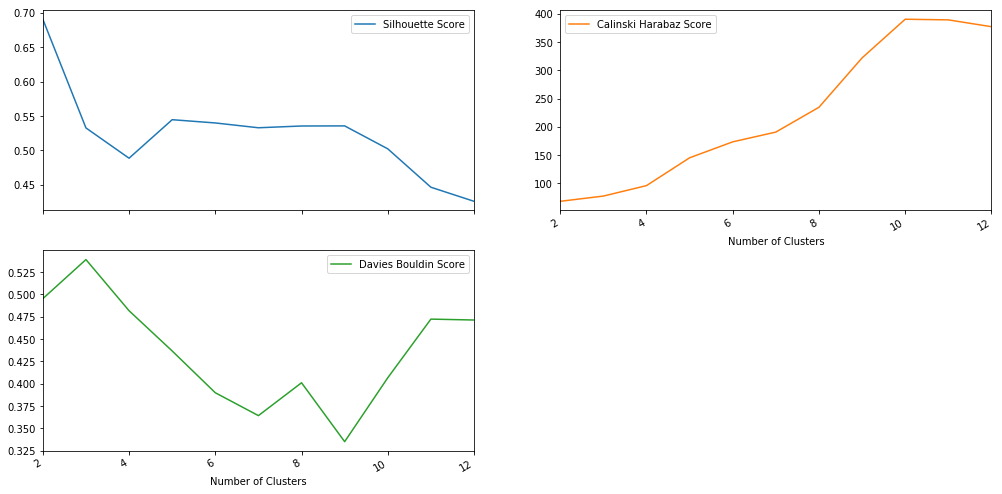

In [45]:
slscrplt = slscr.plot(x='Number of Clusters',kind='line', subplots = True, figsize =[17,9], legend = True, layout=(2, 2))
slscrplt

<span style="font-size: 16px;">From the above, using the elbow method one can see that according to Silhouette Coefficient the optimum number of clusters is 4 and according to Calinski-Harabaz Index the optimum number of index is 4. As for Davies-Bouldin Index values closer to zero indicate a better partition and in our case that value is 0.335160 corresponding to number of clusters = 9. We will go with the majority and partition the neighborhood into 4 clusters</span>

## Results and Discussion <a name="results"></a>

### The Clusters of Neighborhood

<span style="font-size: 16px;">Let's partition the neighborhoods into 4 partitions using the K-Mean clustering algorithm</span>

In [33]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_data_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 1, 2, 1, 1, 2, 2], dtype=int32)

<span style="font-size: 16px;">Let's merge the cluster labels and neighborhood data</span>

In [34]:
final_data_cluster = final_data_mean.copy()
final_data_cluster['Cluster Labels'] = kmeans.labels_
final_data_cluster.head()

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts,Cluster Labels
0,Borivali,19.230733,72.856673,327975.0,59,4,8.672414,325.758621,468.465517,706.810345,2
1,Dahisar,19.249436,72.859628,312006.0,43,5,6.727273,258.945455,591.236364,793.600000,2
2,Magathane,19.220206,72.866687,306369.0,30,0,5.000000,300.085714,783.828571,1037.314286,2
3,Mulund,19.172554,72.942537,305878.0,45,4,6.903226,298.741935,580.758065,864.709677,2
4,Vikhroli,19.092161,72.918940,234880.0,59,3,14.679245,542.509434,963.301887,1260.132075,1


<span style="font-size: 16px;">Let's examine the partitions(clusters) generated above</span>

<span style="font-size: 14px;"> First Cluster (Cluster Labels =  0)

In [35]:
clst1 = final_data_cluster.loc[final_data_cluster['Cluster Labels'] == 0]
clst1

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts,Cluster Labels
24,Bandra West,19.054772,72.830338,226508.0,70,4,34.149425,1465.275862,2153.091954,3225.632184,0
29,Worli,18.998641,72.817360,262507.0,39,1,27.163636,1570.000000,2803.836364,3740.509091,0
33,Mumbadevi,18.952389,72.831268,233527.0,74,5,28.837500,1340.975000,2078.412500,3023.150000,0
34,Colaba,18.906703,72.814712,248586.0,92,7,28.844444,1378.622222,1788.000000,2472.033333,0


<span style="font-size: 14px;">The above cluster contains all neighborhoods with high average count values signifying greater accessibility potential. It contains a neighborhood with high accessibility(average count) and only 1 Chinese restaurant</span>

<span style="font-size: 14px;"> Second Cluster (Cluster Labels =  1)

In [36]:
clst2 = final_data_cluster.loc[final_data_cluster['Cluster Labels'] == 1]
clst2

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts,Cluster Labels
4,Vikhroli,19.092161,72.918940,234880.0,59,3,14.679245,542.509434,963.301887,1260.132075,1
6,Jogeshwari East,19.143897,72.842771,286826.0,30,6,21.043478,575.608696,1015.956522,1410.217391,1
7,Dindoshi,19.176218,72.861698,294966.0,38,2,16.600000,757.911111,1584.066667,1977.711111,1
10,Malad West,19.188954,72.835543,297683.0,60,5,15.250000,694.816667,1402.466667,1778.066667,1
12,Versova,19.135085,72.814610,209407.0,28,3,17.916667,684.750000,1020.458333,1518.791667,1
13,Andheri West,19.136325,72.827660,256600.0,62,6,18.558824,744.941176,1144.588235,1745.720588,1
14,Andheri East,19.113645,72.869734,273219.0,76,3,10.679487,640.397436,886.769231,1273.179487,1
16,Chandivali,19.107491,72.901760,417734.0,49,3,23.078431,827.156863,1255.333333,1813.960784,1
21,Kurla,19.072630,72.884472,239207.0,23,3,12.791667,785.208333,1475.791667,2042.375000,1
22,Kalina,19.076277,72.865400,226508.0,48,3,13.947368,918.368421,1252.947368,1872.500000,1


<span style="font-size: 14px;">The above cluster contains all neighborhoods with more than 1 or more than 1 Chinese restaurants and moderate count values. Not a candidate cluster</span>

<span style="font-size: 14px;"> Third Cluster (Cluster Labels =  2)

In [37]:
clst3 = final_data_cluster.loc[final_data_cluster['Cluster Labels'] == 2]
clst3

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts,Cluster Labels
0,Borivali,19.230733,72.856673,327975.0,59,4,8.672414,325.758621,468.465517,706.810345,2
1,Dahisar,19.249436,72.859628,312006.0,43,5,6.727273,258.945455,591.236364,793.600000,2
2,Magathane,19.220206,72.866687,306369.0,30,0,5.000000,300.085714,783.828571,1037.314286,2
3,Mulund,19.172554,72.942537,305878.0,45,4,6.903226,298.741935,580.758065,864.709677,2
5,Bhandup West,19.162370,72.937632,296610.0,28,1,8.083333,380.222222,799.222222,1032.111111,2
8,Kandivali East,19.199821,72.842594,270721.0,37,2,7.863636,384.250000,808.250000,1198.568182,2
9,Charkop,19.210045,72.818349,306447.0,26,3,6.148148,206.851852,333.444444,463.888889,2
11,Goregaon,19.166257,72.852570,337688.0,34,1,9.695652,380.913043,748.173913,1075.043478,2
17,Ghatkopar West,19.090806,72.907667,285276.0,8,0,5.600000,171.600000,282.800000,347.000000,2
18,Ghatkopar East,19.078599,72.910146,249807.0,27,0,12.535714,462.214286,766.928571,1178.392857,2


<span style="font-size: 14px;">The above cluster contains all neighborhoods with no Chinese restaurants and moderate average count values. This cluster is a possible candidate for picking the neighborhood for opening a Chinese restaurant</span>

<span style="font-size: 14px;"> Fourth Cluster (Cluster Labels =  3)

In [48]:
clst4 = final_data_cluster.loc[final_data_cluster['Cluster Labels'] == 3]
clst4

,Neighborhood,Latitude,Longitude,Above 18 Population,All Restaurant Count,Chinese Restaurant Count,Venue Tips Count,Venue User Counts,Venue Checkin Counts,Venue Visits Counts,Cluster Labels
15,Vile Parle,19.096793,72.851695,270735.0,67,3,30.486111,1926.125,3437.472222,5264.041667,3


<span style="font-size: 14px;">The above cluster contains all neighborhood with 3 Chinese restaurant and highest average counts. Not a candidate cluster</span>

### Discussion

Data Exploration and Clustering both point to similar results for the next neighborhood for opening a new Chinese restaurant. These being 

1. Ghatkopar East with no Chinese restaurant and good average counts (12.53 tip counts, 462.21 user counts, 766.89 check-in counts, 1178.35 visit count)
2. Bandra East with just 1 Chinese restaurant and good average counts (10.58 tip counts, 550.30 user counts, 702.05 check-in counts, 1107.08 visit count)
3. Worli, though not part of the same cluster as above two, but with only one Chinese restaurant and high average counts (27.14 tip counts, 1569.89 user counts, 2803.56 check-in counts, 3740.23 visit count) is also a good candidate.

As can be seen from the bar plots of restaurant counts above, the Mumbai city has scope not only for Chinese but other authentic cuisine restaurants. An approach like this report can be taken for finding location for other authentic cuisine restaurants.


## Conclusion <a name="conclusion"></a>

Mumbai neighborhood data has been collected from Wikipedia and foursquare.com, analyzed and location for Chinese restaurant has been recommended using K-means clustering. Though the data is limited (eg. population data is about 18+ years only) the results are still good and usable. Three Potential neighborhoods namely <b>Ghatkopar East, Bandra East</b> and <b>Worli</b> were identified for opening a new Chinese restaurant. 

Better data for parameters used for analysis in this report and data for other parameters mentioned in problem section would yield better results.

Mumbai city has good eating out crowd and hence has scope for other authentic cuisine restaurants. Approach like this report can be used for predicting other cuisine restaurants.